In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import seaborn as sns
import importlib
from tqdm import tqdm
import setglobals as gl

utils.set_figure_style(scale="1col")

sns.set_palette("colorblind")


In [181]:
### DATA LOADING
### Change gl.data_dir to your data directory in setglobals.py before running
data = pd.read_csv(gl.data_dir + 'SL3_Forces.csv', sep = '\t')
data['forceVector'] = data[[col for col in data.columns if col.startswith('PC_')]].apply(lambda x: np.array(x), axis=1)
# data = data.drop(columns=[col for col in data.columns if col.startswith('PC_')])

# change correspondingly for each experiment
n_trials_per_block = 20
n_blocks_per_day = 20
n_trials_per_day = n_trials_per_block * n_blocks_per_day
n_days = 3

# - SubNum: Subject number (e.g., 1 to 16 (exlcuding 8))
# - BN: Block number
# - TN: Trial number within the block (integer, from 1 to n_trials_per_block)
# - ET: Execution time in milliseconds
# - day: Day of the experiment (from 1 to n_days)
# - isError: Boolean flag indicating if the trial was an error (True/False)
# - T: Overall trial number across the experiment
# - seq: Sequence identifier (integer)
# - hand: Hand used (integer, e.g., 0 or 1 for left/right)
# - points: Points scored in the trial (-1 for error, 0, 1, or 3 for correct)
# - forceVector: Numpy array of force components after PCA

print(data.columns.tolist())  # To list the column names


['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'SubNum', 'BN', 'TN', 'ET', 'day', 'isError', 'T', 'seq', 'hand', 'points', 'forceVector']


In [214]:
class PolicyModel:
    def __init__(self, data, learning_rate = 0.1, beta = 0.95):
        self.data = data
        self.learning_rate = learning_rate
        self.beta = beta
        self.ETs = data['ET'].values
        self.isErrors = data['isError'].values
        self.learning_rate_cov = learning_rate / 100
        # self.learning_rate_cov = 0
        self.cov_update_cut_off = 0.5
        self.cov_update_cut_off = 0.5
        # self.cov_update_cut_off = 0.2
        # self.cov_update_cut_off = 0.01

        self.mean_update_cut_off = 1
        self.mean_update_cut_off = 0.5
        self.mean_update_cut_off = 0.1



    def set_initial_mean(self, initial_mean):
        self.mean = initial_mean

    def set_initial_cov_eigs(self, initial_cov_eigs):
        self.cov_eigs = initial_cov_eigs

    def set_initial_average_ET(self, initial_average_ET):
        self.average_ET = initial_average_ET

    def generate_action(self):
        action = np.random.multivariate_normal(self.mean, np.diag(np.exp(self.cov_eigs)))
        return action
    
    def get_ET_of_state(self, state):
        et = self.ETs[state]
        return et
    
    def get_error_of_state(self, state):
        isError = self.isErrors[state]
        return isError
    
    def evalaute_reward(self, state):
        if not self.get_error_of_state(state):
            # reward = -(self.get_ET_of_state(state) - self.average_ET) / 100
            reward = -(self.get_ET_of_state(state) - self.average_ET) / 20
        else: 
            reward = 0
        return reward
    
    def update_average_ET(self, state):
        et = self.get_ET_of_state(state)
        if not self.get_error_of_state(state):
            self.average_ET = (1 - self.beta) * self.average_ET + self.beta * et
        else:
            pass

    def update_mean(self, action, reward):
        update = self.learning_rate * reward * (action - self.mean)
        if (update > self.mean_update_cut_off).any():
            # print("Large mean update detected:", update)
            update = np.clip(update, -self.mean_update_cut_off, self.mean_update_cut_off)
        self.mean = self.mean + update

    def update_cov(self, action, reward):
        update = 1 / 2 * self.learning_rate_cov * reward * (((action - self.mean) ** 2) * np.exp(self.cov_eigs * -1) - 1)
        if (update > self.cov_update_cut_off).any():
            # print("Large covariance update detected:", update)
            update = np.clip(update, -self.cov_update_cut_off, self.cov_update_cut_off)
        self.cov_eigs = self.cov_eigs + update


In [215]:
# Main simulation loop
model_data = []
for subnum, subdata in data.groupby('SubNum'):
    print(f"Simulating for Subject {subnum}")
    model = PolicyModel(subdata, learning_rate=0.1, beta=0.95)
    initial_mean = np.zeros(len(subdata.iloc[0]['forceVector']))
    initial_cov_eigs = np.zeros(len(subdata.iloc[0]['forceVector']))
    # set first correct trial's ET as initial average ET
    initial_ET = subdata[subdata['isError'] == False].iloc[0]['ET']
    
    model.set_initial_mean(initial_mean)
    model.set_initial_cov_eigs(initial_cov_eigs)
    model.set_initial_average_ET(initial_ET)

    actions = []
    rewards = []
    for state in tqdm(range(len(subdata))):
        action = model.generate_action()
        reward = model.evalaute_reward(state)
        model.update_average_ET(state)
        model.update_mean(action, reward)
        model.update_cov(action, reward)

        row = {'SubNum': subnum, 'T': state + 1}
        for i in range(len(action)):
            row[f'PC_{i+1}'] = action[i]

        model_data.append(row)


model_data = pd.DataFrame(model_data) 


Simulating for Subject 1


100%|██████████| 1200/1200 [00:00<00:00, 9159.82it/s]


Simulating for Subject 2


100%|██████████| 1200/1200 [00:00<00:00, 8593.61it/s]


Simulating for Subject 3


100%|██████████| 1200/1200 [00:00<00:00, 9880.21it/s] 


Simulating for Subject 4


100%|██████████| 1200/1200 [00:00<00:00, 10111.65it/s]


Simulating for Subject 5


100%|██████████| 1200/1200 [00:00<00:00, 10063.65it/s]


Simulating for Subject 6


100%|██████████| 1200/1200 [00:00<00:00, 10187.03it/s]


Simulating for Subject 7


100%|██████████| 1200/1200 [00:00<00:00, 10112.58it/s]


Simulating for Subject 9


100%|██████████| 1200/1200 [00:00<00:00, 9974.74it/s] 


Simulating for Subject 10


100%|██████████| 1200/1200 [00:00<00:00, 10143.01it/s]


Simulating for Subject 11


100%|██████████| 1200/1200 [00:00<00:00, 8938.89it/s]


Simulating for Subject 12


100%|██████████| 1200/1200 [00:00<00:00, 9288.29it/s]


Simulating for Subject 13


100%|██████████| 1200/1200 [00:00<00:00, 9872.16it/s]


Simulating for Subject 14


100%|██████████| 1200/1200 [00:00<00:00, 9025.88it/s]


Simulating for Subject 15


100%|██████████| 1200/1200 [00:00<00:00, 9991.67it/s] 


Simulating for Subject 16


100%|██████████| 1200/1200 [00:00<00:00, 9939.95it/s]


In [216]:
# join model_data with original data replacing forceVector with Action
model_data = model_data.merge(data.drop(columns = [f'PC_{i+1}' for i in range(15)]), on = ['SubNum', 'T'])


Text(0.5, 1.0, 'Histogram of Model Actions across all PC components')

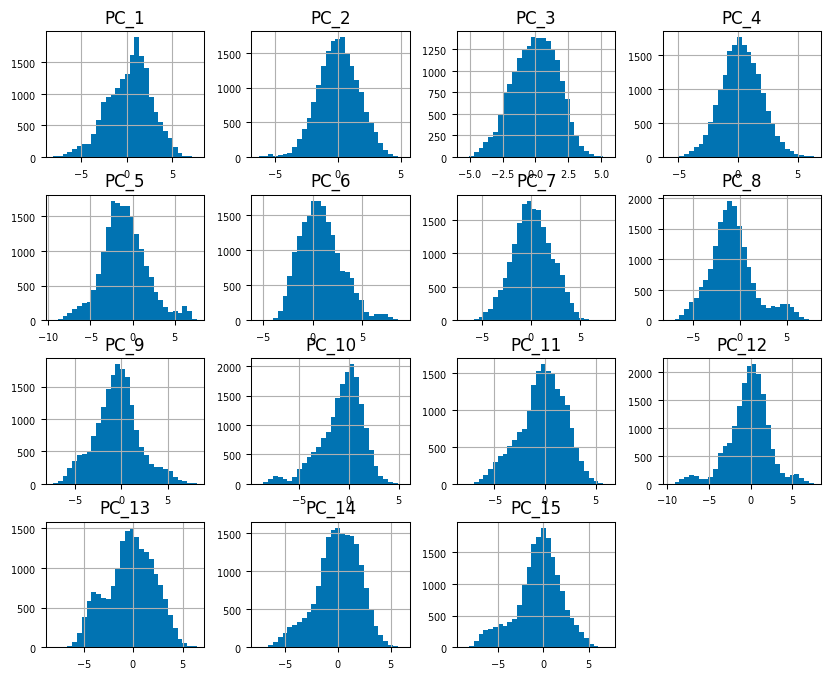

In [217]:
# histogram of all PC components of model actions
model_data[[col for col in model_data.columns if col.startswith('PC_')]].hist(figsize=(10, 8), bins = 30)
plt.title('Histogram of Model Actions across all PC components')

In [218]:
# save model data to csv
model_data.to_csv(gl.data_dir + 'PolicyOptimizationModel.csv', index = False, sep = '\t')